# Changepoint Detection

Changepoint detection is useful when you want to know when the underlying data generation process for a time series has changed. For example, if you were trying to trade the stock market, changepoint detection could be useful to tell you when there is a shift in market trends. In this tutorial, we will walk you through how to use some of the changepoint detection algorithms that are available in functime.

In [7]:
import numpy as np
import plotly.express as px
import polars as pl

## CUSUM
The CUSUM algorithm is one of the most straightforward changepoint detection algorithms available. It works to detect a shift in the mean of a time series. It does need to be tuned to ensure that the number of false positives and false negatives are controlled. The algorithm uses a warmup period to determine the initial mean and standard deviation of a data distribution. Once that warmup period is over, it calculate the cumulative sum of values away from the original mean value using standardized values. Once the cumulative sum of moves exceeds a mean, an event is logged and a new warmup period begins.

The 3 parameters that are available for tuning are:
- Threshold: How far the cumulative value must move from the original mean.
- Warmup Period: How long to calculate the mean and standard deviation for.
- Drift: A parameter that is subtracted from the normalized move on each iteration. This makes it so a lot of small moves will not trigger an event. The move must be large enough that it is bigger than our drift.

Let's take a look below at how we can do this in functime. It is exposed through the plugin system through th `ts` namespace.

In [ ]:
vals = list(np.random.default_rng(seed=0).normal(0.0, 0.1, 150))
vals_2 = list(np.random.default_rng(seed=0).normal(0.2, 0.2, 50))

df = pl.DataFrame({"data": vals + vals_2})

df = df.with_columns(
    pl.col("data")
    .ts.cusum(threshold=5.0, warmup_period=50, drift=1.0)
    .alias("cusum_event")
)

You can see we have created a time series above that has a very clear changepoint at the 150th data point. Below we will graph the time series, the changepoint, and our algorithms detected changepoint.

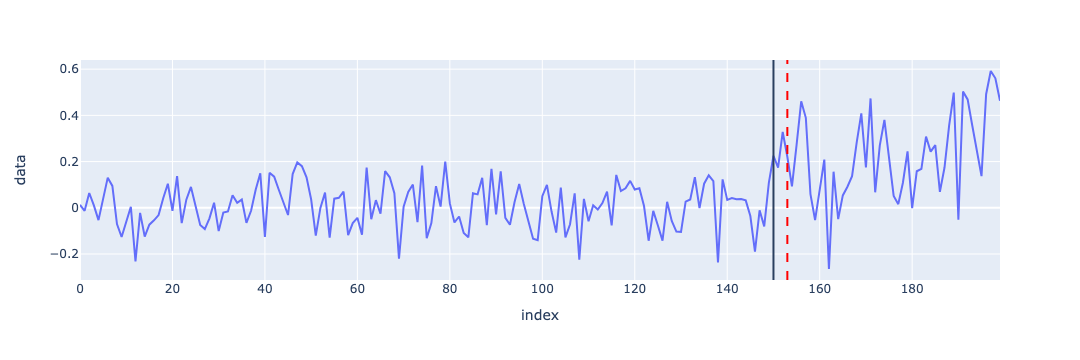

In [8]:
events = df.with_row_count().filter(pl.col("cusum_event") == 1)["row_nr"].to_list()
fig = px.line(df, y="data")
fig.add_vline(150)
for e in events:
    fig.add_vline(e, line_dash="dash", line_color="red")
fig.show()

You can see that our simple algorithm does a fairly good job of caputring our changepoint (red dashed line) within just a few time periods of our actual changepoint (black solid line).